# Replication of Pendant Drop paper

## Load Libraries

In [29]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data import load_dataset
from src.visuals import plot_image

## Load Data

Load data generated via solving forward problem. Use `load dataset` to return features and labels. *Features* are the r and z coordinates corresponding to each shape index. A total of N shape indexes are expected. *Labels* are the sigma0 and vol0 non dimensional parameters used to generate the shape.

In [2]:
features, labels = load_dataset('../data/data_2.mat')

# dataset shape
features.shape

(22632, 2, 40)

22.6k shape instances in $ \mathbb{R}^2 $ of 40 evenly spaced points.

In [3]:
from sklearn.model_selection import train_test_split

input_train, input_test, output_train, output_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

## Visualisation of Generated Images

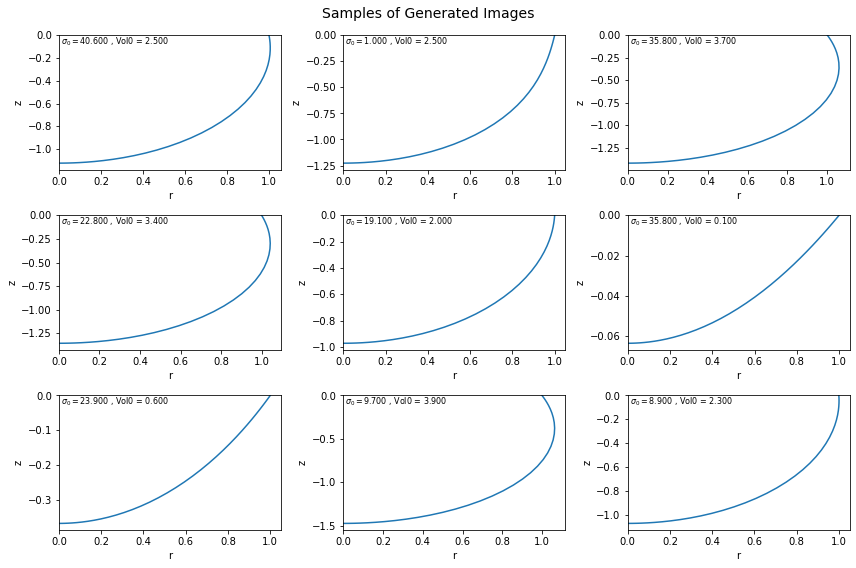

In [63]:
fig, axes = plt.subplots(3, 3,figsize=(12,8))
for i, ax in enumerate(axes.flatten()):
    plot_image(ax, input_train[i*1000], output_train[i*1000])

fig.suptitle('Samples of Generated Images', fontsize=14)
fig.tight_layout()
plt.show()

## Replication of model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Input,Model

In [6]:
model = tf.keras.Sequential([Input(shape=(2,40)),
                             layers.Flatten(),
                             layers.Dense(units=512),
                             layers.LeakyReLU(),
                             layers.Dense(units=1024),
                             layers.LeakyReLU(),
                             layers.Dense(units=256),
                             layers.LeakyReLU(),
                             layers.Dense(units=16),
                             layers.LeakyReLU(),
                             layers.Dense(units=2)])

In [8]:
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adadelta(),loss=tf.keras.losses.MeanSquaredError())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               41472     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='../logs/kierfield_epochs', profile_batch=(0,100000))
history = model.fit(input_train, output_train, epochs=100000,batch_size=150,verbose=0,validation_split=0.1, callbacks=[tensorboard_callback])


KeyboardInterrupt: 

In [81]:
model.save('./models/kierfield_base_40k.h5')

## Model Evaluation 

1. Test set
2.  With additive noise

In [82]:
output_predict = model.predict(input_test)
model.evaluate(input_test,output_test)

142/142 [==============================] - 0s 2ms/step - loss: 11.5611


11.56109619140625

In [83]:
output_test.T[0]

array([15.5, 47.3, 32.9, ..., 38.3, 20.6, 34. ])

Text(0.5, 1.0, 'Plot of actual against predicted')

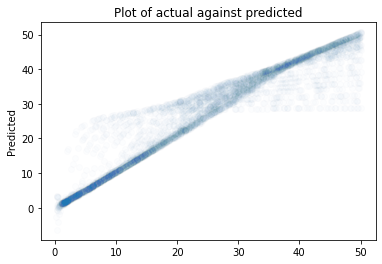

In [90]:
plt.scatter(output_test.T[0], output_predict.T[0], alpha=0.01)
plt.ylabel('Predicted')
plt.title('Plot of actual against predicted')

In [ ]:
insample_predict = model.predict(input_train)
plt.scatter(output_train.T[0],insample_predict.T[0], alpha=0.01)
plt.ylabel('Predicted')
plt.title('Plot of actual against predicted')

In [ ]:
566*150

In [86]:
model.evaluate(input_train,output_train)

566/566 [==============================] - 1s 2ms/step - loss: 11.3014


11.301387786865234

In [87]:
# add noise to train input
noise = np.random.normal(0,0.001,input_train.shape)
noise_input = noise + input_train

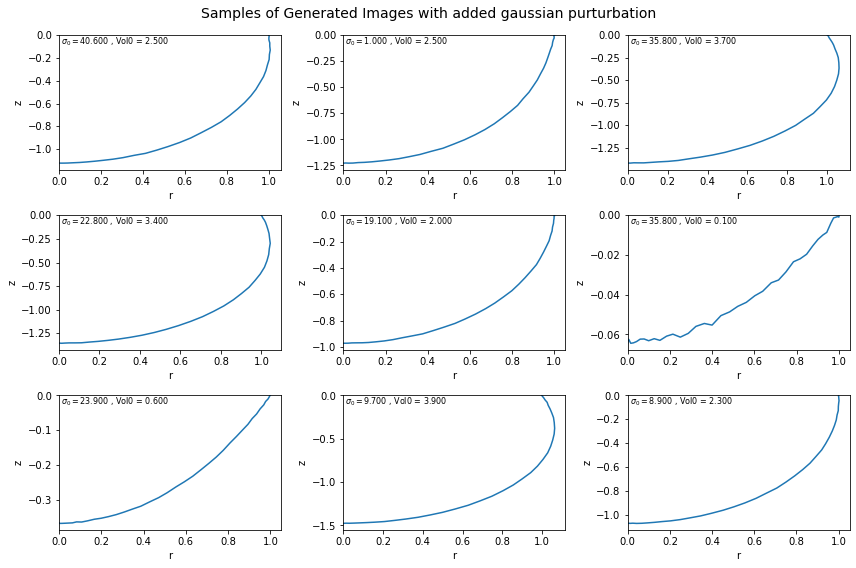

In [88]:
fig, axes = plt.subplots(3, 3,figsize=(12,8))
for i, ax in enumerate(axes.flatten()):
    plot_image(ax, noise_input[i*1000], output_train[i*1000])

fig.suptitle('Samples of Generated Images with added gaussian purturbation', fontsize=14)
fig.tight_layout()
plt.show()

In [89]:
display(model.evaluate(noise_input,output_train))

566/566 [==============================] - 1s 2ms/step - loss: 52.6791


52.67913055419922

In [ ]:
inputs = layers.Input(shape=(2,40),name='Input')
flatten = layers.Flatten(name='flatten')(inputs)
dense_first = layers.Dense(units=512, name='first_layer')(flatten)
leaky_first = layers.LeakyReLU(name='leaky_first')(dense_first)
dense_second = layers.Dense(units=1024, name='second_layer')(leaky_first)
leaky_second = layers.LeakyReLU(name='leaky_second')(dense_second)
dense_third = layers.Dense(units=256, name='third_layer')(leaky_second)
leaky_third = layers.LeakyReLU(name='leaky_third')(dense_third)
dense_fourth = layers.Dense(units=16, name='fourth_layer')(leaky_third)
leaky_fourth = layers.LeakyReLU(name='leaky_fourth')(dense_fourth)
sigma_output = layers.Dense(units=1, name='sigma0_layer')(leaky_fourth)
vol_output = layers.Dense(units=1, name='vol0_layer')(leaky_fourth)

model = Model(inputs=inputs, outputs=[sigma_output, vol_output])